In [1]:
!pip install transformers datasets evaluate

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torchtext
import gensim.downloader
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.types import Device
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from prompt_toolkit import output
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.nn.init import xavier_uniform_

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

%matplotlib inline
plt.style.use('ggplot')

C:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data, EDA, data preprocessing

### Loading data

In [3]:
train_raw_data = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/train.csv', index_col=0)
final_test_raw_data = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/test.csv')

print(f'Shape of train: {train_raw_data.shape}')
print(f'Shape of test: {final_test_raw_data.shape}')

Shape of train: (41159, 2)
Shape of test: (3798, 2)


### Working with missing data

Let's look at the data:


In [4]:
train_raw_data.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41159 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41158 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 964.7+ KB


We can see that there are rows with missing data. Let's look at them:

In [6]:
train_raw_data[train_raw_data['Sentiment'].isnull() == True]

,Text,Sentiment
33122,@PrivyCouncilCA #SocialDistancing isnÂt enoug...,NaN
NaN,Neutral,NaN
39204,@TanDhesi @foreignoffice @Afzal4Gorton @Expres...,NaN
Neutral,NaN,NaN


Let's drop these rows from our DataFrame because they don't carry much value and let's look at the data again:

In [7]:
train_raw_data = train_raw_data.dropna().reset_index(drop=True)
print(f'New shape of train: {train_raw_data.shape}')

New shape of train: (41155, 2)


In [8]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41155 entries, 0 to 41154
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41155 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


Let's look at the lines of texts:

(array([ 530., 3268., 4924., 6560., 6257., 7495., 8516., 3053.,  529.,
          23.]),
 array([ 1. ,  7.3, 13.6, 19.9, 26.2, 32.5, 38.8, 45.1, 51.4, 57.7, 64. ]),
 <BarContainer object of 10 artists>)

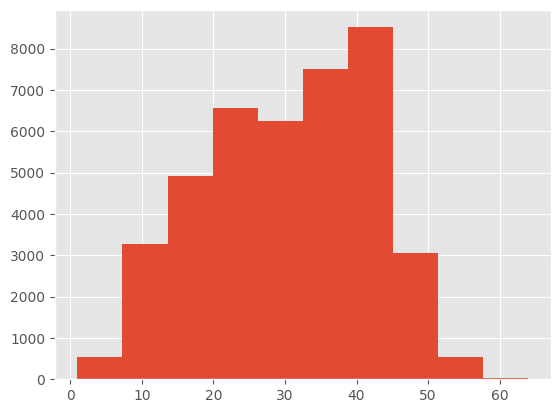

In [9]:
plt.hist([len(text.split()) for text in train_raw_data['Text']])

(array([ 24., 231., 356., 477., 543., 623., 701., 629., 199.,  15.]),
 array([ 2.,  8., 14., 20., 26., 32., 38., 44., 50., 56., 62.]),
 <BarContainer object of 10 artists>)

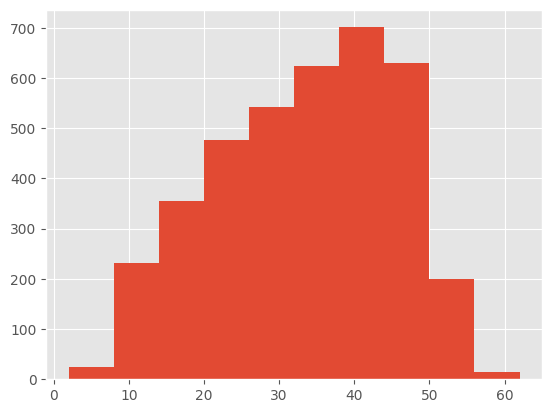

In [10]:
plt.hist([len(text.split()) for text in final_test_raw_data['Text']])

There are no sequences that are too long and the distributions in the training and test samples are similar. It is good.

### Label encoding of target column

In [11]:
train_raw_data['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [12]:
le = LabelEncoder()
le.fit(train_raw_data['Sentiment'])
train_raw_data['Sentiment'] = le.transform(train_raw_data['Sentiment'])
train_raw_data.head(5)

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,advice Talk to your neighbours family to excha...,4
2,Coronavirus Australia: Woolworths to give elde...,4
3,My food stock is not the only one which is emp...,4
4,"Me, ready to go at supermarket during the #COV...",0


## For LSTM model

### Сleaning text from useless data

Let's look at the text more closely:

In [ ]:
train_raw_data['Text'].sample(10, random_state=42).values

array(['So panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people #CoronaVirus #StopPanicBuying #Covid_19',
       'I would place a large amount of money this is the guy buying 90 of the toilet paper',
       '"Saudi Arabia is bracing for an economic downturn as oil prices plummet due to the #coronavirus pandemic" https://t.co/PQ3eRX9euZ',
       '#Foodsecurity #coronavirus #covid19 \r\r\n1.Smooth flow of global trade will help secure food supply\r\r\n2.Monitoring food prices and markets\r\r\n3.Sharing relevant information transparently\r\r\n4.Supporting the vulnerable countries and populationsÂ\x85https://t.co/tTPmInVVgS https://t.co/Ums3Eueu6J',
       'I d like to know who is stockpiling eggs cheese and ice cream and why I m used to going without as our local Lidl has been running out of all kinds of stuff for years way before Drives me potty Going to the supermarket is like entering a lottery',
       'Whenever you tou

In [ ]:
def text_cleaner(text: str) -> str:
    '''will clean from unicode, url, hashtags, numbers,
    nicknames, lower'''
    # text = re.sub(r'[.,#!$%\^&\*;:{}=\-_`~()]',r'',text) # punct.
    
    # text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]', r'', text)# unicode

    text = re.sub(r'(\\[a-z])', r'', text)
    
    text = re.sub(r'http\S+', r'', text)# url
    
    text = re.sub('@[A-Za-z0-9_-]+', r'', text)# nickname
    
    text = re.sub(r'#([^\s]+)', r'\1', text)# hashtag symbol
    
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:',
                  '', text) # emoji
    
    text = ''.join([i for i in text if not i.isdigit()])# int.
    
    text = text.lower()
    return text

In [ ]:
train_raw_data['Text'] = train_raw_data['Text'].apply(text_cleaner)
final_test_raw_data['Text'] = final_test_raw_data['Text'].apply(text_cleaner)
train_raw_data['Text'].sample(10, random_state=42).values

array(['so panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people coronavirus stoppanicbuying covid_',
       'i would place a large amount of money this is the guy buying  of the toilet paper',
       '"saudi arabia is bracing for an economic downturn as oil prices plummet due to the coronavirus pandemic" ',
       'foodsecurity coronavirus covid \r\r\n.smooth flow of global trade will help secure food supply\r\r\n.monitoring food prices and markets\r\r\n.sharing relevant information transparently\r\r\n.supporting the vulnerable countries and populations ',
       'i d like to know who is stockpiling eggs cheese and ice cream and why i m used to going without as our local lidl has been running out of all kinds of stuff for years way before drives me potty going to the supermarket is like entering a lottery',
       'whenever you touch any object or surface outside your abode washyourhands with soapandwater\r\r\n\r\r\nstay

### Tokenization

In [ ]:
tokenizer = get_tokenizer('basic_english')

def build_vocabulary(datasets):
  for dataset in datasets:
    for text in dataset['Text']:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_raw_data, final_test_raw_data]), specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

In [ ]:
print(f'Vocabulary length: {vocab.__len__()}')

Vocabulary length: 50653


### Splitting of training data

We need to split our train_raw_data by train, validation and test samples in the proportions of 60:20:20.

However, our data contain texts for 5 classes, so it is necessary to keep stratification after their splitting.

In [ ]:
# first, we will split data by two samples: train and test in the proportion of 60:40
train_data, test_data = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['Sentiment'], random_state=42)
# then, we will split test data by two samples: validation and test in the proportion of 50:50 
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Sentiment'], random_state=42)

Check the stratification:

In [ ]:
train_raw_data['Sentiment'].value_counts(normalize=True)

4    0.277536
2    0.240967
3    0.187365
1    0.160952
0    0.133179
Name: Sentiment, dtype: float64

In [ ]:
train_data['Sentiment'].value_counts(normalize=True)

4    0.277518
2    0.240979
3    0.187371
1    0.160946
0    0.133186
Name: Sentiment, dtype: float64

In [ ]:
val_data['Sentiment'].value_counts(normalize=True)

4    0.277521
2    0.240826
3    0.187363
1    0.161118
0    0.133171
Name: Sentiment, dtype: float64

In [ ]:
test_data['Sentiment'].value_counts(normalize=True)

4    0.277697
2    0.241011
3    0.187318
1    0.160836
0    0.133139
Name: Sentiment, dtype: float64

In [ ]:
print(f'Shape of the train_data: {train_data.shape}')
print(f'Shape of the val_data: {val_data.shape}')
print(f'Shape of the test_data: {test_data.shape}')
print(f'Shape of the finel_test_raw_data: {final_test_raw_data.shape}')

Shape of the train_data: (32924, 2)
Shape of the val_data: (4115, 2)
Shape of the test_data: (4116, 2)
Shape of the finel_test_raw_data: (3798, 2)


## For transfer learning

In [13]:
def text_cleaner(text: str) -> str:
    '''will clean from unicode, url, hashtags, numbers,
    nicknames, lower'''
    # text = re.sub(r'[.,#!$%\^&\*;:{}=\-_`~()]',r'',text) # punct.
    
    # text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]', r'', text)# unicode

    text = re.sub(r'(\\[a-z])', r'', text)
    
    text = re.sub(r'http\S+', r'', text)# url
    
    text = re.sub('@[A-Za-z0-9_-]+', r'', text)# nickname
    
    text = re.sub(r'#([^\s]+)', r'\1', text)# hashtag symbol
    
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:',
                  '', text) # emoji
    
    text = ''.join([i for i in text if not i.isdigit()])# int.
    
    text = text.lower()
    return text

In [14]:
train_raw_data['Text'] = train_raw_data['Text'].apply(text_cleaner)
final_test_raw_data['Text'] = final_test_raw_data['Text'].apply(text_cleaner)
train_raw_data['Text'].sample(10, random_state=42).values

array(['so panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people coronavirus stoppanicbuying covid_',
       'i would place a large amount of money this is the guy buying  of the toilet paper',
       '"saudi arabia is bracing for an economic downturn as oil prices plummet due to the coronavirus pandemic" ',
       'foodsecurity coronavirus covid \r\r\n.smooth flow of global trade will help secure food supply\r\r\n.monitoring food prices and markets\r\r\n.sharing relevant information transparently\r\r\n.supporting the vulnerable countries and populations ',
       'i d like to know who is stockpiling eggs cheese and ice cream and why i m used to going without as our local lidl has been running out of all kinds of stuff for years way before drives me potty going to the supermarket is like entering a lottery',
       'whenever you touch any object or surface outside your abode washyourhands with soapandwater\r\r\n\r\r\nstay

In [15]:
# first, we will split data by two samples: train and test in the proportion of 60:40
train_data, test_data = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['Sentiment'], random_state=42)
# then, we will split test data by two samples: validation and test in the proportion of 50:50 
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Sentiment'], random_state=42)

In [16]:
# Data processing
import pandas as pd
import numpy as np

# Modeling
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, get_scheduler

# Progress bar
from tqdm.auto import tqdm

# Hugging Face Dataset
from datasets import Dataset

# Model performance evaluation
import evaluate

In [17]:
# Convert pyhton dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_val_data = Dataset.from_pandas(val_data)
hg_test_data = Dataset.from_pandas(test_data)
hg_subm_data = Dataset.from_pandas(final_test_raw_data)

print(hg_train_data)
print(hg_val_data)
print(hg_test_data)
print(hg_subm_data)

Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 32924
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 4115
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__'],
    num_rows: 4116
})
Dataset({
    features: ['id', 'Text'],
    num_rows: 3798
})


In [ ]:
checkpoint = "LIALLIES/finetune-bert-base-cased"

# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Take a look at the tokenizer
tokenizer

BertTokenizerFast(name_or_path='LIALLIES/finetune-bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [19]:
# Mapping between special tokens and their IDs.
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unknown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The pad token is {tokenizer.pad_token} and the ID for the pad token is {tokenizer.pad_token_id}.')
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')

The unknown token is [UNK] and the ID for the unknown token is 100.
The seperator token is [SEP] and the ID for the seperator token is 102.
The pad token is [PAD] and the ID for the pad token is 0.
The sentence level classification token is [CLS] and the ID for the classification token is 101.
The mask token is [MASK] and the ID for the mask token is 103.


In [20]:
# Funtion to tokenize data
def tokenize_function(data):
    return tokenizer(data["Text"],
                     max_length=40,
                     truncation=True)

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_function, batched=True)
dataset_val = hg_val_data.map(tokenize_function, batched=True)
dataset_test = hg_test_data.map(tokenize_function, batched=True)
dataset_subm = hg_subm_data.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)
print(dataset_subm)

Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32924
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4115
})
Dataset({
    features: ['Text', 'Sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4116
})
Dataset({
    features: ['id', 'Text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3798
})


In [22]:
# Remove the review and index columns because it will not be used in the model
dataset_train = dataset_train.remove_columns(["Text", "__index_level_0__"])
dataset_val = dataset_val.remove_columns(["Text", "__index_level_0__"])
dataset_test = dataset_test.remove_columns(["Text", "__index_level_0__"])
dataset_subm = dataset_subm.remove_columns(["Text", "id"])

# Rename label to labels because the model expects the name labels
dataset_train = dataset_train.rename_column("Sentiment", "labels")
dataset_val = dataset_val.rename_column("Sentiment", "labels")
dataset_test = dataset_test.rename_column("Sentiment", "labels")

# Change the format to PyTorch tensors
dataset_train.set_format("torch")
dataset_val.set_format("torch")
dataset_test.set_format("torch")
dataset_subm.set_format("torch")

# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)
print(dataset_subm)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32924
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4115
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4116
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3798
})


In [23]:
# Empty cache
torch.cuda.empty_cache()

BATCH_SIZE = 128

# DataLoader
train_dataloader = DataLoader(dataset=dataset_train, shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator)
val_dataloader = DataLoader(dataset=dataset_val, batch_size=BATCH_SIZE, collate_fn=data_collator)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, collate_fn=data_collator)
subm_dataloader = DataLoader(dataset=dataset_subm, batch_size=BATCH_SIZE, collate_fn=data_collator)

In [24]:
# inspect the batch
for batch in train_dataloader:
  break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([128]),
 'input_ids': torch.Size([128, 40]),
 'token_type_ids': torch.Size([128, 40]),
 'attention_mask': torch.Size([128, 40])}

In [25]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)

In [26]:
# pass one batch to this model to make sure that everything is ok
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.6408, grad_fn=<NllLossBackward0>) torch.Size([128, 5])


In [27]:
# Number of epochs
num_epochs = 7

# Number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Optimizer
optimizer = AdamW(params=model.parameters(), lr=3e-5)

# Set up the learning rate scheduler
lr_scheduler = get_scheduler(name="linear", 
                             optimizer=optimizer, 
                             num_warmup_steps=0, 
                             num_training_steps=num_training_steps)

print(f'Number of the training steps: {num_training_steps}')

Number of the training steps: 1806


In [28]:
# Use GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


 14%|█▍        | 258/1806 [02:10<10:02,  2.57it/s]

1: {'recall': {'recall': 0.6981773997569867}, 'precision': {'precision': 0.7030726521618594}, 'f1': {'f1': 0.6987839091424787}, 'accuracy': {'accuracy': 0.6981773997569867}}


 29%|██▊       | 516/1806 [04:21<08:15,  2.60it/s]

2: {'recall': {'recall': 0.7317132442284325}, 'precision': {'precision': 0.7389380009798202}, 'f1': {'f1': 0.7323181129810726}, 'accuracy': {'accuracy': 0.7317132442284325}}


 43%|████▎     | 774/1806 [06:33<06:34,  2.62it/s]

3: {'recall': {'recall': 0.7278250303766707}, 'precision': {'precision': 0.7344513141843177}, 'f1': {'f1': 0.7293564052804884}, 'accuracy': {'accuracy': 0.7278250303766707}}


 57%|█████▋    | 1032/1806 [08:44<04:55,  2.62it/s]

4: {'recall': {'recall': 0.7419198055893074}, 'precision': {'precision': 0.746876597828415}, 'f1': {'f1': 0.7429948326386683}, 'accuracy': {'accuracy': 0.7419198055893074}}


 71%|███████▏  | 1290/1806 [10:54<03:16,  2.62it/s]

5: {'recall': {'recall': 0.7339003645200486}, 'precision': {'precision': 0.7367190335298804}, 'f1': {'f1': 0.7346412209947677}, 'accuracy': {'accuracy': 0.7339003645200486}}


 86%|████████▌ | 1548/1806 [13:04<01:38,  2.63it/s]

6: {'recall': {'recall': 0.73681652490887}, 'precision': {'precision': 0.739791516495611}, 'f1': {'f1': 0.7376352608722484}, 'accuracy': {'accuracy': 0.73681652490887}}


100%|██████████| 1806/1806 [15:15<00:00,  2.60it/s]

7: {'recall': {'recall': 0.7358444714459296}, 'precision': {'precision': 0.7385238217761383}, 'f1': {'f1': 0.7365954264258288}, 'accuracy': {'accuracy': 0.7358444714459296}}


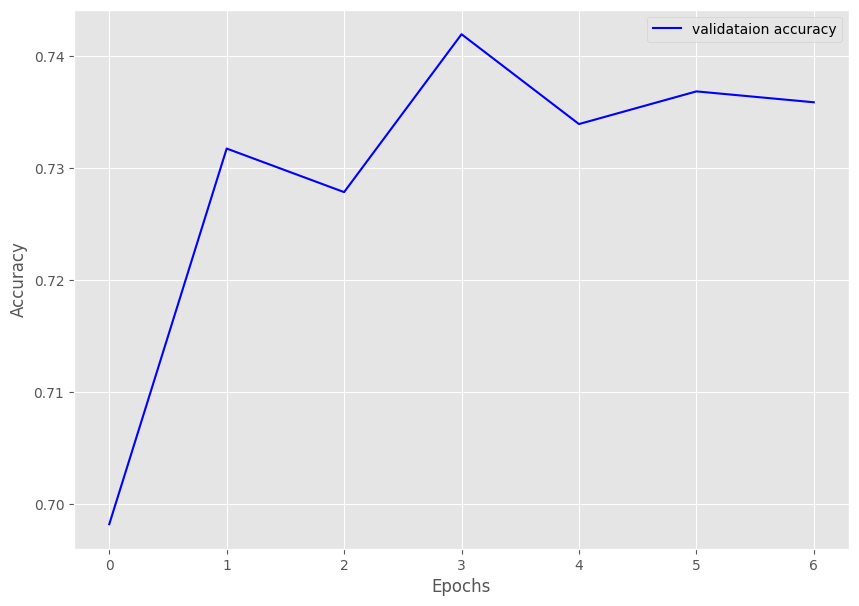

In [29]:
recall_metric = evaluate.load('recall')
precision_metric = evaluate.load('precision')
f1_metric = evaluate.load('f1')
accuracy_metric = evaluate.load('accuracy')

# Set the progress bar
progress_bar = tqdm(range(num_training_steps))

best_accuracy = 0
prec_list_to_plot = []
rec_list_to_plot = []
f1_list_to_plot = []
acc_list_to_plot = []

# Loop through the epochs
for epoch in range(1, num_epochs + 1):
    # Tells the model that we are training the model
    model.train()
    # Loop through the batches
    for batch in train_dataloader:
        # Get the batch
        batch = {k: v.to(device) for k, v in batch.items()}
        # Compute the model output for the batch
        outputs = model(**batch)
        # Loss computed by the model
        loss = outputs.loss
        # backpropagates the error to calculate gradients
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Learning rate scheduler
        lr_scheduler.step()
        # Clear the gradients
        optimizer.zero_grad()
        # Update the progress bar
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        recall_metric.add_batch(predictions=predictions, references=batch['labels'])
        precision_metric.add_batch(predictions=predictions, references=batch['labels'])
        f1_metric.add_batch(predictions=predictions, references=batch['labels'])
        accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
    
    results = {
        'recall': recall_metric.compute(average='weighted'),
        'precision': precision_metric.compute(average='weighted'),
        'f1': f1_metric.compute(average='weighted'),
        'accuracy': accuracy_metric.compute()
    }
    
    print(
        f'{epoch}:',
        {
            key: value
            for key, value in results.items()
        },
    )

    prec_list_to_plot.append(results['recall'])
    rec_list_to_plot.append(results['precision'])
    f1_list_to_plot.append(results['f1'])
    acc_list_to_plot.append(results['accuracy']['accuracy'])

    if results['accuracy']['accuracy'] > best_accuracy:
        best_accuracy = results['accuracy']['accuracy']
        model.save_pretrained('best_model')
    
model.save_pretrained('final_model')

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    acc_list_to_plot, color='blue',
    linestyle='-', label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')

In [ ]:
progress_bar = tqdm(range(len(test_dataloader)))

# Evaluation
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
        
    recall_metric.add_batch(predictions=predictions, references=batch['labels'])
    precision_metric.add_batch(predictions=predictions, references=batch['labels'])
    f1_metric.add_batch(predictions=predictions, references=batch['labels'])
    accuracy_metric.add_batch(predictions=predictions, references=batch['labels'])
    progress_bar.update(1)
    
results = {
        'recall': recall_metric.compute(average='weighted'),
        'precision': precision_metric.compute(average='weighted'),
        'f1': f1_metric.compute(average='weighted'),
        'accuracy': accuracy_metric.compute()
    }
    
print(
        {
            key: value
            for key, value in results.items()
        },
    )

In [41]:
# inspect the batch
for batch in subm_dataloader:
  break
{k: v.shape for k, v in batch.items()}

In [50]:
progress_bar = tqdm(range(len(subm_dataloader)))
# Submission
model.eval()
submissions = []
for batch in subm_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    submissions.append(predictions)
    progress_bar.update(1)


In [54]:
final_submissions = [int(x) for y in submissions for x in y]

In [56]:
len(final_submissions)

3798

In [57]:
final_submissions = le.inverse_transform(final_submissions)
final_submissions

array(['Negative', 'Extremely Positive', 'Extremely Positive', ...,
       'Neutral', 'Extremely Negative', 'Extremely Positive'],
      dtype=object)

https://medium.com/grabngoinfo/transfer-learning-for-text-classification-using-pytorch-5e52045d55f8

## LSTM model

### Creating datasets

In [ ]:
train_dataset, val_dataset, test_dataset, final_test_dataset = to_map_style_dataset(train_data.values), \
                                                               to_map_style_dataset(val_data.values), \
                                                               to_map_style_dataset(test_data.values), \
                                                               to_map_style_dataset(final_test_raw_data.values)

MAX_WORDS  = 50
BATCH_SIZE = 1024

def vectorize_batch(batch):
  X, Y = list(zip(*batch))
  X = [vocab(tokenizer(text)) for text in X] # tokenize and map tokens to indexes
  X = [tokens+([0]*(MAX_WORDS - len(tokens))) if len(tokens) < MAX_WORDS else tokens[:MAX_WORDS] for tokens in X]
  return torch.tensor(X, dtype=torch.int32, device='cpu'), torch.tensor(Y, device='cpu')


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
val_loader  = DataLoader(val_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
final_test_loader  = DataLoader(final_test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch)

### Building model

In [ ]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


We are building a variation of the RNN: LSTM model.

After many attempts of training, our model will be multilayerd (the results are better only with regularization in the optimizer), bidirectional, with dropout and initialization of the hidden state using a Xavier's uniform distribution. LogSoftmax will be used as the activation function at the last level.

Adam with regularization will be used as an optimizer (the results without regularization were worse, and overfitting begins much early).

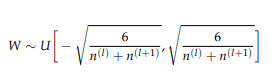

In [ ]:
EMBED_LEN  = 50
HIDDEN_DIM = 75
N_LAYERS   = 3

target_classes = train_raw_data['Sentiment'].unique()

class LSTMClassifier(nn.Module):
  def __init__(self):
    super(LSTMClassifier, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, dropout=0.5, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(in_features=HIDDEN_DIM*2, out_features=len(target_classes))
    self.softmax = nn.LogSoftmax(dim=1)
  
  def init_hidden(self, batch_size):
    '''Initializes hidden state'''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data
    
    if (train_on_gpu):
      # 2*NUM_LAYERS is num_directions*num_layers (2 if bidirectional, else 1)
      hidden = (xavier_uniform_(weight.new(2*N_LAYERS, batch_size, HIDDEN_DIM)).cuda(),
                xavier_uniform_(weight.new(2*N_LAYERS, batch_size, HIDDEN_DIM)).cuda())
    else:
      # 2*NUM_LAYERS is num_directions*num_layers (2 if bidirectional, else 1)
      hidden = (xavier_uniform_(weight.new(2*N_LAYERS, batch_size, HIDDEN_DIM)),
                xavier_uniform_(weight.new(2*N_LAYERS, batch_size, HIDDEN_DIM)))
    return hidden

  def forward(self, X_batch, hidden):
    emb = self.emb_layer(X_batch)
    output, hidden = self.lstm(emb, hidden)
    output = self.fc(output[:, -1])
    output = self.softmax(output)
    return output, hidden

In [ ]:
lstm_classifier = LSTMClassifier()

lstm_classifier

LSTMClassifier(
  (emb_layer): Embedding(50653, 50)
  (lstm): LSTM(50, 75, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=150, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
for layer in lstm_classifier.children():
  print(f'Layer: {layer}')
  print('Parameters: ')
  for param in layer.parameters():
    print(param.shape)
  print()

Layer: Embedding(50653, 50)
Parameters: 
torch.Size([50653, 50])

Layer: LSTM(50, 75, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
Parameters: 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])
torch.Size([300, 150])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer: Linear(in_features=150, out_features=5, bias=True)
Parameters: 
torch.Size([5, 150])
torch.Size([5])

Layer: LogSoftmax(dim=1)
Parameters: 



### Save model and plots

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, path
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch}\n")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, path + 'best_model.pth')
            

def save_model(epochs, model, optimizer, criterion, path):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, path + 'final_model.pth')
    

def save_plots(valid_acc, train_loss, valid_loss, path):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(path + 'accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(path + 'loss.png')


save_best_model = SaveBestModel()

### Training loop and calculation validation loss and accuracy


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
  with torch.no_grad():
    Y_shuffled, Y_preds, losses = [], [], []
    for X, Y in val_loader:

      # initialise hidden state
      h = model.init_hidden(X.shape[0])

      preds, h = model(X, h)
      loss = loss_fn(preds, Y)
      losses.append(loss.item())

      Y_shuffled.append(Y)
      Y_preds.append(preds.argmax(dim=-1))

    Y_shuffled = torch.cat(Y_shuffled)
    Y_preds = torch.cat(Y_preds)

    valid_loss = torch.tensor(losses).cpu().mean()
    valid_acc = accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())

    print(f'Valid Loss: {valid_loss:.3f}')
    print(f'Valid Acc : {valid_acc:.3f}')

    return valid_loss, valid_acc


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, device, epochs=10, path='/checkpoints/'):
  train_losses, val_losses, val_accs = [], [], []
  for i in range(1, epochs+1):
    losses = []
    for X, Y in tqdm(train_loader):
      X.to(device)
      Y.to(device)
      model.to(device)

      # initialise hidden state
      h = model.init_hidden(X.shape[0])

      Y_preds, h = model(X, h)

      loss = loss_fn(Y_preds, Y)
      losses.append(loss.item())

      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

    train_loss = torch.tensor(losses).mean()
    print(f'Train Loss: {train_loss:.3f}')
    valid_loss, valid_acc = CalcValLossAndAccuracy(model, loss_fn, val_loader)

    # save the best model
    save_best_model(valid_loss, i, model, optimizer, loss_fn, path)

    # append losses and accuracy to lists
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

  # save the trained model weights for a final time
  save_model(i, model, optimizer, loss_fn, path)
  # save the loss and accuracy plots
  save_plots(val_accs, train_losses, val_losses, path)

### Launching the model



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

100%|██████████| 33/33 [02:21<00:00,  4.30s/it]


Train Loss: 1.549
Valid Loss: 1.508
Valid Acc : 0.297

Best validation loss: 1.507659912109375

Saving best model for epoch: 1



100%|██████████| 33/33 [02:11<00:00,  3.98s/it]


Train Loss: 1.512
Valid Loss: 1.479
Valid Acc : 0.307

Best validation loss: 1.4793065786361694

Saving best model for epoch: 2



100%|██████████| 33/33 [02:09<00:00,  3.92s/it]


Train Loss: 1.472
Valid Loss: 1.503
Valid Acc : 0.351


100%|██████████| 33/33 [02:08<00:00,  3.88s/it]


Train Loss: 1.352
Valid Loss: 1.400
Valid Acc : 0.428

Best validation loss: 1.4001935720443726

Saving best model for epoch: 4



100%|██████████| 33/33 [02:15<00:00,  4.11s/it]


Train Loss: 1.173
Valid Loss: 1.179
Valid Acc : 0.583

Best validation loss: 1.1789215803146362

Saving best model for epoch: 5



100%|██████████| 33/33 [02:12<00:00,  4.00s/it]


Train Loss: 0.941
Valid Loss: 0.943
Valid Acc : 0.651

Best validation loss: 0.9432958364486694

Saving best model for epoch: 6



100%|██████████| 33/33 [02:14<00:00,  4.07s/it]


Train Loss: 0.782
Valid Loss: 0.757
Valid Acc : 0.716

Best validation loss: 0.7566543817520142

Saving best model for epoch: 7



100%|██████████| 33/33 [02:12<00:00,  4.02s/it]


Train Loss: 0.642
Valid Loss: 0.698
Valid Acc : 0.749

Best validation loss: 0.6984459161758423

Saving best model for epoch: 8



100%|██████████| 33/33 [02:15<00:00,  4.12s/it]


Train Loss: 0.525
Valid Loss: 0.662
Valid Acc : 0.764

Best validation loss: 0.6616674661636353

Saving best model for epoch: 9



100%|██████████| 33/33 [02:16<00:00,  4.13s/it]


Train Loss: 0.441
Valid Loss: 0.694
Valid Acc : 0.777


100%|██████████| 33/33 [02:12<00:00,  4.01s/it]


Train Loss: 0.380
Valid Loss: 0.660
Valid Acc : 0.772

Best validation loss: 0.6603682637214661

Saving best model for epoch: 11



100%|██████████| 33/33 [02:14<00:00,  4.06s/it]


Train Loss: 0.345
Valid Loss: 0.690
Valid Acc : 0.783


100%|██████████| 33/33 [02:18<00:00,  4.20s/it]


Train Loss: 0.311
Valid Loss: 0.658
Valid Acc : 0.792

Best validation loss: 0.6584254503250122

Saving best model for epoch: 13



100%|██████████| 33/33 [02:15<00:00,  4.10s/it]


Train Loss: 0.288
Valid Loss: 0.656
Valid Acc : 0.800

Best validation loss: 0.6558635234832764

Saving best model for epoch: 14



100%|██████████| 33/33 [02:13<00:00,  4.06s/it]


Train Loss: 0.267
Valid Loss: 0.656
Valid Acc : 0.790
Saving final model...


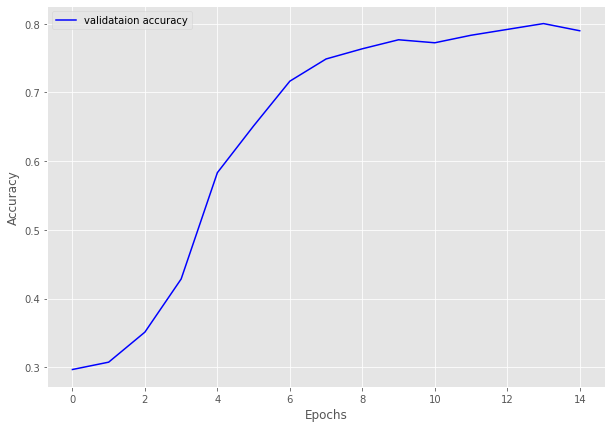

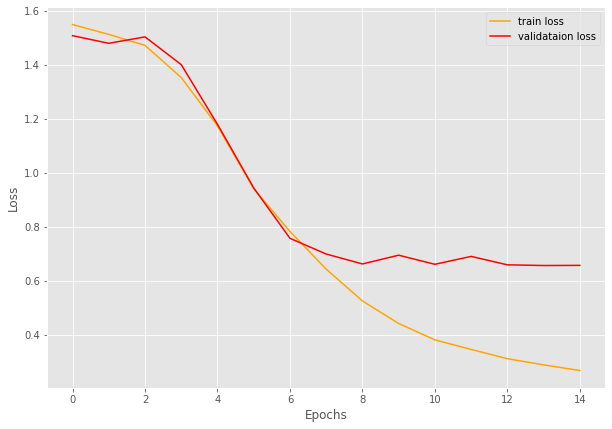

In [ ]:
EPOCHS  = 15
LR      = 1e-2
OPT     = Adam(lstm_classifier.parameters(), lr=LR, weight_decay=5e-5)
LOSS_FN = nn.CrossEntropyLoss()
MODEL   = lstm_classifier
PATH    = '/content/checkpoints/'

TrainModel(model=MODEL, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS, path=PATH)

### Loading the saved model

In [ ]:
checkpoint = torch.load('/content/checkpoints/final_model.pth')
MODEL.load_state_dict(checkpoint['model_state_dict'])
OPT.load_state_dict(checkpoint['optimizer_state_dict'])
EPOCHS = checkpoint['epoch']
LOSS_FN = checkpoint['loss']

# if we need to continue training
# MODEL.train()
# if we need to inference
MODEL.eval()

LSTMClassifier(
  (emb_layer): Embedding(50653, 50)
  (lstm): LSTM(50, 75, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=150, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

### Test accuracy

In [ ]:
def MakePredictions(model, loader, device):
  Y_shuffled, Y_preds= [], []
  for X, Y in loader:
    X.to(device)
    Y.to(device)
    # initialise hidden state
    h = model.init_hidden(X.shape[0])
    preds, h = model(X, h)
    Y_preds.append(preds)
    Y_shuffled.append(Y)
  gc.collect()
  Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

  return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1)

Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader, device)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

target_classes_ = le.inverse_transform(target_classes)
print(f'Test Accuracy: {accuracy_score(Y_actual, Y_preds)}')
print('\nClassification report: ')
print(classification_report(Y_actual, Y_preds, target_names=target_classes_))
print('\nConfusion Matrix: ')
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy: 0.8131681243926142

Classification report: 
                    precision    recall  f1-score   support

           Neutral       0.88      0.77      0.82       548
          Positive       0.89      0.80      0.84       662
Extremely Negative       0.75      0.81      0.78       992
          Negative       0.88      0.83      0.86       771
Extremely Positive       0.77      0.83      0.80      1143

          accuracy                           0.81      4116
         macro avg       0.83      0.81      0.82      4116
      weighted avg       0.82      0.81      0.81      4116


Confusion Matrix: 
[[421   0 120   3   4]
 [  0 530   5   2 125]
 [ 56   2 804  37  93]
 [  2   3  58 640  68]
 [  2  60  87  42 952]]


### What else can be done to improve?



1.   Experiment with the regularization of the optimizer or try another optimizer.
2.   Experiment with the 'gain' parameter of the Xavier's initialization or try another method of the initialization hidden state.
3. Try another activation function.
4. Try using some pretrained embeddings.
5. Try using another tokenizators.
6. Try changing the text cleaning method.



## Transfer learning